In [ ]:
from google.colab import drive 
drive.mount('/saurabh' , force_remount = True) 

Mounted at /saurabh


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Jan  3 13:26:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pip install mcfly

# **Import important libraries**

In [ ]:
import os
import statistics
import csv
import itertools
import tensorflow as tf
import keras

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sn

from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import *
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import mcfly
from numpy import mean
from numpy import std


In [ ]:
cd /saurabh/My Drive/Datasets/har/wisdm-dataset/

/saurabh/My Drive/Datasets/har/wisdm-dataset


In [ ]:
ls

activity_key.txt             HARWatchGRU_Optuna.csv
arff_files/                  inception/
arffmagic-master/            inception_phone/
change_raw_act.pl            model1_plot.png
data/                        model_plot2.png
deepconv1/                   model_plot3.png
deepconvlstm/                model_plot4.png
HAR_Simple_Keras.csv         model_plot_cnnlstm.png
HAR_Simple_model_000003.h5   model_plot.png
HAR_Simple_Optuna.csv        multichannel.png
HARTrain1_Keras.csv          phone.df
HARTrain1_model_000013.h5    raw/
HARTrain1_Optuna.csv         README.txt
HARTrain_Keras.csv           resnet/
HARTrain_Optuna.csv          watch.df
HARWatchGRU_Keras.csv        WISDM-dataset-description.pdf
HARWatchGRU_model_000000.h5


In [ ]:
phone = pd.read_pickle('phone.df')

In [ ]:
phone.shape

(4780251, 9)

## **Mapping the 18 activities into 3 Groups**

In [ ]:
def activity_mapper(activity):
    if(activity in ['A', 'B', 'C', 'D', 'E', 'M']):
        return 0
    elif(activity in ['P', 'O', 'F', 'Q', 'R','G', 'S']):
        return 1
    else:
        return 2
phone['activity'] = phone['activity'].apply(activity_mapper)

In [ ]:
phone.activity.value_counts()

1    1843466
0    1614563
2    1322222
Name: activity, dtype: int64

In [ ]:
activity_map = {
    0: 'Ambulation Oriented',
    1: 'Hand Oriented General',
    2: 'Hand Oriented Eating'
}

In [ ]:
activities = sorted(activity_map.keys())
activity_encoding = {v: k for k, v in enumerate(activities)}

## **Data Transformation using a sliding windows of 10 seconds = 200 (10 * 20) data points and stride of 50**

In [ ]:
window_size = 200
stride = 50
frames = []
for i in tqdm(range(0, len(phone)-window_size, stride)):
    window = phone.iloc[i:i+window_size]
    if window['activity'].nunique() == 1:
      frames.append(window)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [ ]:
#activities = sorted(act_map.keys())
#activity_encoding = {v: k for k, v in enumerate(activities)}

X_list = []
y_list = []

#for each frame replace label with activity
for frame in tqdm(frames):
    X_list.append(frame[['phone_accel_x', 'phone_accel_y', 'phone_accel_z', 'phone_gyro_x', 'phone_gyro_y', 'phone_gyro_z']].values)
    y_list.append(activity_encoding[frame.iloc[0]['activity']])
    #y_list.append(frame.iloc[0][['activity']].values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
X = np.array(X_list)
y = np.array(to_categorical(y_list))

In [ ]:
print(X.shape)
print(y.shape)

(94115, 200, 6)
(94115, 3)


In [ ]:
print(X.shape[1:])

(200, 6)


# **Train , Validation , Test Split**

In [ ]:
#data split: as informed by slides split for 30,000 examples 
#our example is a window and coming from a big expansive amount of data
#5 second split based on papers using 5 sec split. We can play with this 

X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=42)

#train
print("X_train: ",X_train.shape)

#dev
print("X_val: ",X_val.shape)

#test
print("X_test: ",X_test.shape)

print("Y_train: ",y_train.shape)
print("Y_val: ",y_val.shape)
print("Y_test: ",y_test.shape)

X_train:  (56469, 200, 6)
X_val:  (18823, 200, 6)
X_test:  (18823, 200, 6)
Y_train:  (56469, 3)
Y_val:  (18823, 3)
Y_test:  (18823, 3)


In [ ]:
num_classes = y_train.shape[1]
metric = 'accuracy'

In [ ]:
print(num_classes)

3


In [ ]:
models = mcfly.modelgen.generate_models(X_train.shape,
                                        number_of_classes=num_classes,
                                        number_of_models = 4,
                                        model_types = ['ResNet'],
                                        metrics=[metric])

In [ ]:
models_to_print = range(len(models))
for i, item in enumerate(models):
    if i in models_to_print:
        model, params, model_types = item
        print("-------------------------------------------------------------------------------------------------------")
        print("Model " + str(i))
        print(" ")
        print("Hyperparameters:")
        print(params)
        print(" ")
        print("Model description:")
        model.summary()
        print(" ")
        print("Model type:")
        print(model_types)
        print(" ")

-------------------------------------------------------------------------------------------------------
Model 0
 
Hyperparameters:
{'learning_rate': 0.0007352144016931533, 'regularization_rate': 0.0003499571747048207, 'network_depth': 4, 'min_filters_number': 58, 'max_kernel_size': 20}
 
Model description:
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 6)]     0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 200, 6)       24          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 200, 58)      7018        batch_normalizatio

In [ ]:
pwd

'/saurabh/My Drive/Datasets/har/wisdm-dataset'

In [ ]:
directory_to_extract_to = os.path.join('.', 'resnetsmarphone')

In [ ]:
# Define directory where the results, e.g. json file, will be stored
resultpath = os.path.join(directory_to_extract_to, 'models')
if not os.path.exists(resultpath):
    os.makedirs(resultpath)

In [ ]:
print('X shape:', X_train.shape)
print('y shape:', y_train.shape)

X shape: (56469, 200, 6)
y shape: (56469, 3)


In [ ]:
from mcfly.find_architecture import train_models_on_samples

outputfile = os.path.join(resultpath, 'modelcomparison.json')
histories, val_accuracies, val_losses = train_models_on_samples(X_train, y_train,
                                                                X_val, y_val,
                                                                models, nr_epochs=25,
                                                                subset_size= None,
                                                                early_stopping_patience = 3,
                                                                verbose=True,
                                                                outputfile=outputfile,
                                                                metric=metric,batch_size = 64)

/usr/local/lib/python3.6/dist-packages/mcfly/find_architecture.py:134: UserWarning: Argument 'metric' is deprecated and will be ignored.
  warnings.warn("Argument 'metric' is deprecated and will be ignored.")


Training model 0 ResNet
Epoch 1/25
883/883 [==============================] - 60s 55ms/step - loss: 0.8627 - accuracy: 0.5790 - val_loss: 0.7792 - val_accuracy: 0.6165
Epoch 2/25
883/883 [==============================] - 50s 57ms/step - loss: 0.7568 - accuracy: 0.6261 - val_loss: 0.7172 - val_accuracy: 0.6462
Epoch 3/25
883/883 [==============================] - 51s 58ms/step - loss: 0.7237 - accuracy: 0.6421 - val_loss: 0.6942 - val_accuracy: 0.6481
Epoch 4/25
883/883 [==============================] - 51s 58ms/step - loss: 0.7051 - accuracy: 0.6568 - val_loss: 0.6994 - val_accuracy: 0.6502
Epoch 5/25
883/883 [==============================] - 52s 59ms/step - loss: 0.6836 - accuracy: 0.6694 - val_loss: 0.6544 - val_accuracy: 0.6920
Epoch 6/25
883/883 [==============================] - 52s 59ms/step - loss: 0.6699 - accuracy: 0.6811 - val_loss: 0.6463 - val_accuracy: 0.7008
Epoch 7/25
883/883 [==============================] - 52s 59ms/step - loss: 0.6562 - accuracy: 0.6863 - val_loss

In [ ]:
best_model_index = 2

In [ ]:
best_model_index

2

In [ ]:
best_model, best_params, best_model_types = models[best_model_index]
print(best_model_index, best_model_types, best_params)

2 ResNet {'learning_rate': 0.0003304420988397601, 'regularization_rate': 0.00048039148842037396, 'network_depth': 2, 'min_filters_number': 96, 'max_kernel_size': 15}


In [ ]:
best_params

{'learning_rate': 0.0003304420988397601,
 'max_kernel_size': 15,
 'min_filters_number': 96,
 'network_depth': 2,
 'regularization_rate': 0.00048039148842037396}

In [ ]:
best_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200, 6)]     0                                            
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 200, 6)       24          input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_28 (Conv1D)              (None, 200, 96)      8736        batch_normalization_23[0][0]     
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 200, 96)      384         conv1d_28[0][0]                  
____________________________________________________________________________________________

In [ ]:
from keras.utils.vis_utils import plot_model

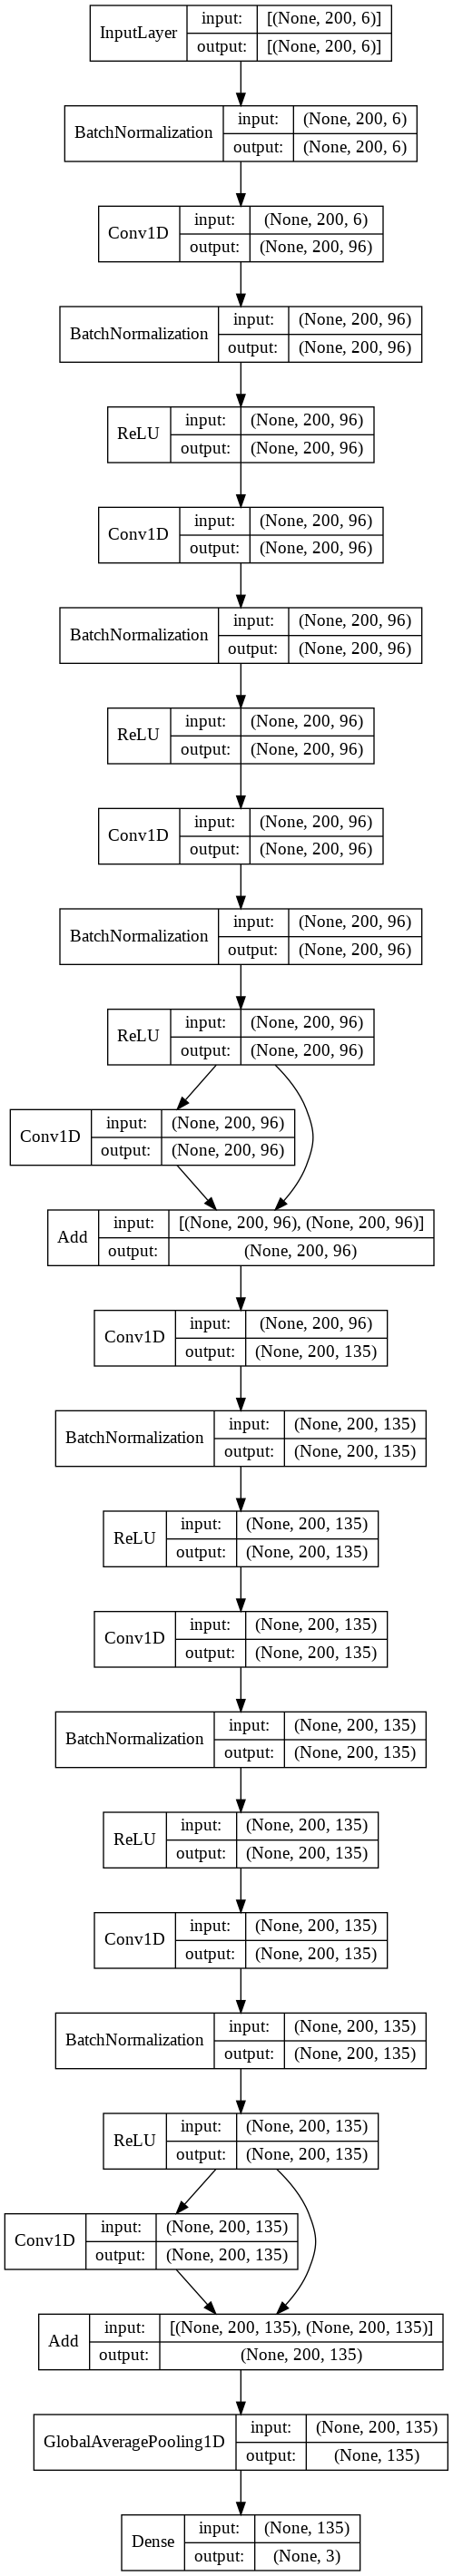

In [ ]:
plot_model(best_model, to_file='model_plot3.png', show_shapes=True,rankdir = 'TB',expand_nested = False,  show_layer_names=False, show_dtype =False)

In [ ]:
# Reverse activity encoding encodes index like 3 -> eating sandwich
reverse_activity_encoding = {v: activity_map[k] for k, v in activity_encoding.items()}
lstm_y_val_pred = best_model.predict(X_val)

y_val_argmax = y_val.argmax(axis=1)
y_val_pred_argmax = lstm_y_val_pred.argmax(axis=1)

lstm_actual_val_activities = [reverse_activity_encoding[i] for i in y_val_argmax]
lstm_predicted_val_activities = [reverse_activity_encoding[i] for i in y_val_pred_argmax]

##### Below is Final Test Set results ######
lstm_y_test_pred = best_model.predict(X_test)
lstm_y_test_argmax = y_test.argmax(axis=1)

lstm_y_test_pred_argmax = lstm_y_test_pred.argmax(axis=1)

lstm_actual_test_activities = [reverse_activity_encoding[i] for i in lstm_y_test_argmax]
lstm_predicted_test_activities = [reverse_activity_encoding[i] for i in lstm_y_test_pred_argmax]

In [ ]:
from sklearn.metrics import classification_report 
print("             Smartphone Results with ResNet for Validation Set\n\n" + classification_report(lstm_predicted_val_activities,lstm_actual_val_activities , digits = 4))
print("             Smartphone Results with ResNet for Test Set\n\n" + classification_report(lstm_predicted_test_activities,lstm_actual_test_activities , digits = 4))

             Smartphone Results with ResNet for Validation Set

                       precision    recall  f1-score   support

  Ambulation Oriented     0.8622    0.8446    0.8533      6527
 Hand Oriented Eating     0.8167    0.7248    0.7680      5915
Hand Oriented General     0.7646    0.8604    0.8097      6381

             accuracy                         0.8123     18823
            macro avg     0.8145    0.8099    0.8103     18823
         weighted avg     0.8148    0.8123    0.8117     18823

             Smartphone Results with ResNet for Test Set

                       precision    recall  f1-score   support

  Ambulation Oriented     0.8625    0.8406    0.8514      6405
 Hand Oriented Eating     0.8116    0.7142    0.7598      5928
Hand Oriented General     0.7629    0.8656    0.8110      6490

             accuracy                         0.8094     18823
            macro avg     0.8123    0.8068    0.8074     18823
         weighted avg     0.8121    0.8094    0.8086  

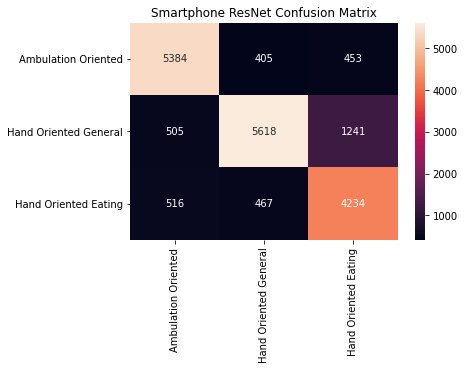

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
lstm_cm = confusion_matrix(lstm_y_test_argmax, lstm_y_test_pred_argmax)
df_cm = pd.DataFrame(lstm_cm, index = [reverse_activity_encoding[i] for i in range(3)], columns = [reverse_activity_encoding[i] for i in range(3)])
#plt.figure(figsize = (12,12))
plt.title('Smartphone ResNet Confusion Matrix')
sns.heatmap(df_cm, annot=True, fmt='g')